In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
import onnxruntime

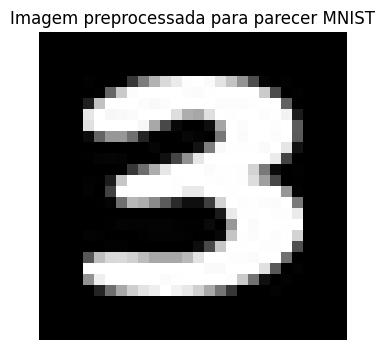

In [4]:
# 1) Lê a imagem em escala de cinza
img_path = "3.png"
img_pil = Image.open(img_path).convert("L")
img_np = np.array(img_pil)

# 2) Se precisar inverter
img_np = 255 - img_np


# 3) Tentar um threshold automático (Otsu)
_, img_bin = cv2.threshold(img_np, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)



# 4) Recortar o dígito
rows = np.any(img_bin, axis=1)
cols = np.any(img_bin, axis=0)

if np.any(rows) and np.any(cols):
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    cropped = img_bin[rmin:rmax+1, cmin:cmax+1]
else:
    cropped = img_bin



# 5) Redimensionar para 20×20
cropped_pil = Image.fromarray(cropped)
cropped_20 = cropped_pil.resize((20, 20), Image.Resampling.LANCZOS)


# 6) Centralizar em 28x28
final_img = Image.new('L', (28, 28), color=0)
left = (28 - 20) // 2
top = (28 - 20) // 2
final_img.paste(cropped_20, (left, top))

# 7) Exiber o resultado final
plt.figure(figsize=(4, 4))
plt.imshow(final_img, cmap='gray')
plt.title("Imagem preprocessada para parecer MNIST")
plt.axis('off')
plt.show()


In [5]:
# Define as mesmas transformações usadas no treinamento do MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Converte a imagem final para tensor e normaliza
img_tensor = transform(final_img)         # shape [1, 28, 28]
img_tensor = img_tensor.unsqueeze(0)      # shape [1, 1, 28, 28] (batch de 1)

# Converte para NumPy (ONNX Runtime trabalha com arrays)
img_np = img_tensor.cpu().numpy()

# Carrega o modelo ONNX
session = onnxruntime.InferenceSession("model.onnx")

# Descobre o nome do input do modelo
input_name = session.get_inputs()[0].name

# Faz a inferência
outputs = session.run(None, {input_name: img_np})

# A saída geralmente é um array de probabilidades/logits
pred = np.argmax(outputs[0])
print("Predição ONNX:", pred)

Predição ONNX: 3
